<a href="https://colab.research.google.com/github/williammcintosh/machine_learning_projects/blob/main/xgboost_sagemaker_cloud_training_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AWS Sagemaker XGBoost

## Will McIntosh

## Purpose

The main purpose of this project was to create a template to work with for my job as a data scientist for Homeoptions. Since the data used for Homeoption was sensitive, displaying this template gives the general idea of the work we did. [Click here for](https://github.com/williammcintosh/machine_learning_projects/tree/main/Hosting_Model_on_Sagemaker) the complete step-by-step tutorial I created.

## Process

I was tasked with creating a hosting a model in AWS that would predict the likelihood of an individual foreclosing on their home in a year. We were asked to make this model available on a website that the sales team could easily make predictions against without any knowledge of coding or datascience. I chose to watch a few tutorials online to learn how to get started and this is the result of that work.

## XGBoost Explained

XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems. It's excellent for datasets with a high number of features which is an issue we had with our project.

## Imports

In [ ]:
import numpy as np
import pandas as pd

import boto3
import re

import sagemaker
from sagemaker import get_execution_role
# SageMaker SDK Documentation: http://sagemaker.readthedocs.io/en/latest/estimators.html

# Data Exploration

In [ ]:
columns = ['count', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek','hour']

In [ ]:
df = pd.read_csv('train.csv', parse_dates=['datetime'],index_col=0)
df_test = pd.read_csv('test.csv', parse_dates=['datetime'],index_col=0)

In [ ]:
df.head()

season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  count  
datetime                                                             
2011-01-01 00:00:00        81        0.0       3          13     16  
2011-01-01 01:00:00        80        0.0       8          32     40  
2011-01-01 02:00:00        80        0.0       5          27     32  
2011-01-01 03:00:00        75        0.0       3          10     13  
2011-01-01 04:00:00        75        0.0       0           1      1

In [ ]:
# We need to convert datetime to numeric for training.
# Let's extract key features into separate numeric columns
def add_features(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

In [ ]:
# Add New Features
add_features(df)
add_features(df_test)

In [ ]:
df.head()

season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  count  year  \
datetime                                                                    
2011-01-01 00:00:00        81        0.0       3          13     16  2011   
2011-01-01 01:00:00        80        0.0       8          32     40  2011   
2011-01-01 02:00:00        80        0.0       5          27     32  2011   
2011-01-01 03:00:00        75        0.0       3          10     13  2011   
2011-01-01 04:00:00        75        0.0       0           1      1  2011   

                     month  day  dayofweek  hour  
datetime                                          
2011-01-01 00:00:00      1    1          5     0  
2011-01-01 01:00:00      1    1          5     1  
2011-01-01 02:00:00      1    1          5     2  
2011-01-01 03:00:00      1    1          5     3  
2011-01-01 04:00:00      1    1          5     4

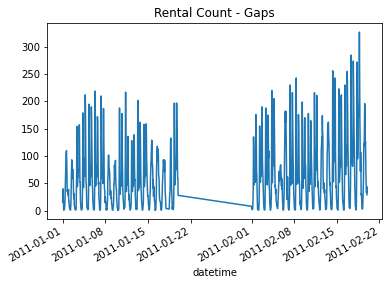

In [ ]:
# Need to predict the missing data
plt.title('Rental Count - Gaps')
df['2011-01':'2011-02']['count'].plot()
plt.show()

/tmp/ipykernel_6987/3377219014.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(df['2011-01-01']['count'])


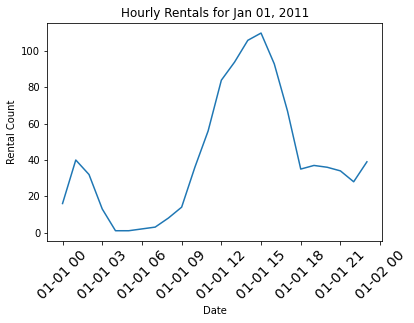

In [ ]:
# Rentals change hourly!
plt.plot(df['2011-01-01']['count'])
plt.xticks(fontsize=14, rotation=45)
plt.xlabel('Date')
plt.ylabel('Rental Count')
plt.title('Hourly Rentals for Jan 01, 2011')
plt.show()

/tmp/ipykernel_6987/3648170626.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(df['2011-01']['count'])


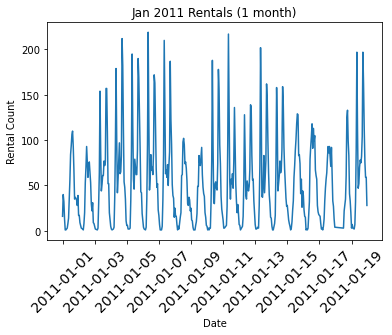

In [ ]:
# Seasonal
plt.plot(df['2011-01']['count'])
plt.xticks(fontsize=14, rotation=45)
plt.xlabel('Date')
plt.ylabel('Rental Count')
plt.title('Jan 2011 Rentals (1 month)')
plt.show()

In [ ]:
group_hour = df.groupby(['hour'])
average_by_hour = group_hour['count'].mean()

Text(0.5, 1.0, 'Average Hourly Rental Count')

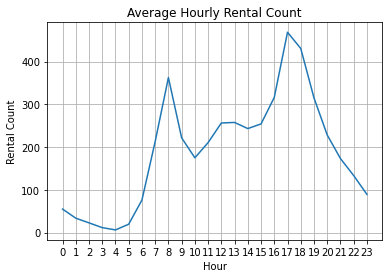

In [ ]:
plt.plot(average_by_hour.index,average_by_hour)
plt.xlabel('Hour')
plt.ylabel('Rental Count')
plt.xticks(np.arange(24))
plt.grid(True)
plt.title('Average Hourly Rental Count')

/tmp/ipykernel_6987/3135732940.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(df['2011']['count'],label='2011')
/tmp/ipykernel_6987/3135732940.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(df['2012']['count'],label='2012')


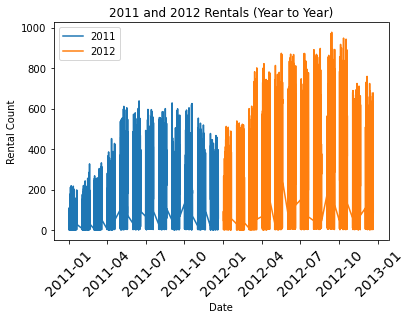

In [ ]:
# Year to year trend
plt.plot(df['2011']['count'],label='2011')
plt.plot(df['2012']['count'],label='2012')
plt.xticks(fontsize=14, rotation=45)
plt.xlabel('Date')
plt.ylabel('Rental Count')
plt.title('2011 and 2012 Rentals (Year to Year)')
plt.legend()
plt.show()

In [ ]:
group_year_month = df.groupby(['year','month'])

In [ ]:
average_year_month = group_year_month['count'].mean()

In [ ]:
average_year_month

year  month
2011  1         54.645012
      2         73.641256
      3         86.849776
      4        111.026374
      5        174.809211
      6        196.877193
      7        203.614035
      8        182.666667
      9        174.622517
      10       174.773626
      11       155.458333
      12       134.173246
2012  1        124.353201
      2        145.646154
      3        208.276923
      4        257.455947
      5        264.109649
      6        287.186404
      7        267.037281
      8        285.570175
      9        292.598684
      10       280.508772
      11       231.980220
      12       217.054825
Name: count, dtype: float64

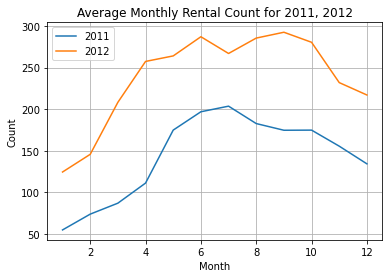

In [ ]:
for year in average_year_month.index.levels[0]:
    plt.plot(average_year_month[year].index,average_year_month[year],label=year)

plt.legend()
plt.xlabel('Month')
plt.ylabel('Count')
plt.grid(True)
plt.title('Average Monthly Rental Count for 2011, 2012')
plt.show()

Text(0.5, 1.0, 'Average Hourly Rental Count - 2011, 2012')

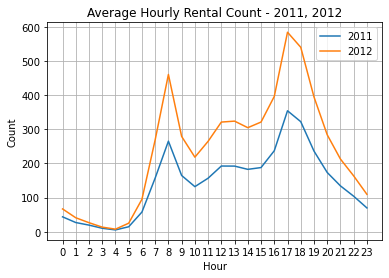

In [ ]:
group_year_hour = df.groupby(['year','hour'])
average_year_hour = group_year_hour['count'].mean()
for year in average_year_hour.index.levels[0]:
    #print (year)
    #print(average_year_month[year])
    plt.plot(average_year_hour[year].index,average_year_hour[year],label=year)

plt.legend()
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(np.arange(24))
plt.grid(True)
plt.title('Average Hourly Rental Count - 2011, 2012')

In [ ]:
group_workingday_hour = df.groupby(['workingday','hour'])
average_workingday_hour = group_workingday_hour['count'].mean()

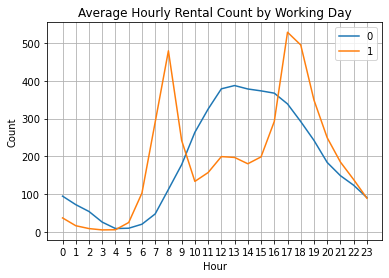

In [ ]:
for workingday in average_workingday_hour.index.levels[0]:
    #print (year)
    #print(average_year_month[year])
    plt.plot(average_workingday_hour[workingday].index,average_workingday_hour[workingday],
             label=workingday)

plt.legend()
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(np.arange(24))
plt.grid(True)
plt.title('Average Hourly Rental Count by Working Day')
plt.show()

In [ ]:
# Let's look at correlation beween features and target
df.corr()['count']

season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
casual        0.690414
registered    0.970948
count         1.000000
year          0.260403
month         0.166862
day           0.019826
dayofweek    -0.002283
hour          0.400601
Name: count, dtype: float64

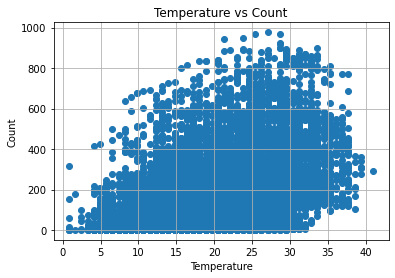

In [ ]:
# Any relation between temperature and rental count?
plt.scatter(x=df.temp,y=df["count"])
plt.grid(True)
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.title('Temperature vs Count')
plt.show()

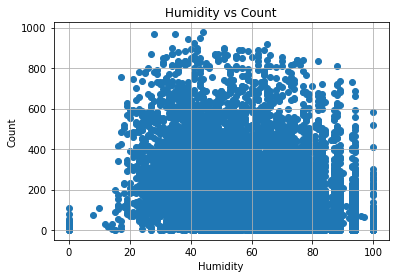

In [ ]:
# Any relation between humidity and rental count?
plt.scatter(x=df.humidity,y=df["count"],label='Humidity')
plt.grid(True)
plt.xlabel('Humidity')
plt.ylabel('Count')
plt.title('Humidity vs Count')
plt.show()

In [ ]:
# Save all data
df.to_csv('bike_all.csv',index=True,index_label='datetime',columns=columns)

# Training and Validation Set

### Target Variable as first column followed by input features
### Training, Validation files do not have a column header

In [ ]:
# Training = 70% of the data
# Validation = 30% of the data
# Randomize the datset
np.random.seed(5)
l = list(df.index)
np.random.shuffle(l)
df = df.loc[l]

In [ ]:
rows = df.shape[0]
train = int(.7 * rows)
test = rows-train

In [ ]:
rows, train, test

(10886, 7620, 3266)

In [ ]:
columns

['count',
 'season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'month',
 'day',
 'dayofweek',
 'hour']

In [ ]:
# Write Training Set
df.iloc[:train].to_csv('bike_train.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [ ]:
# Write Validation Set
df.iloc[train:].to_csv('bike_validation.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [ ]:
# Test Data has only input features
df_test.to_csv('bike_test.csv',index=True,index_label='datetime')

In [ ]:
print(','.join(columns))

count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour


In [ ]:
# Write Column List
with open('bike_train_column_list.txt','w') as f:
    f.write(','.join(columns))

# Upload Data to S3

In [ ]:
# Specify your bucket name
bucket_name = 'xgboost-hosted-model-bucket'

training_folder = r'bikerental/training/'
validation_folder = r'bikerental/validation/'
test_folder = r'bikerental/test/'

s3_model_output_location = r's3://{0}/bikerental/model'.format(bucket_name)
s3_training_file_location = r's3://{0}/{1}'.format(bucket_name,training_folder)
s3_validation_file_location = r's3://{0}/{1}'.format(bucket_name,validation_folder)
s3_test_file_location = r's3://{0}/{1}'.format(bucket_name,test_folder)

In [ ]:
print(s3_model_output_location)
print(s3_training_file_location)
print(s3_validation_file_location)
print(s3_test_file_location)

s3://xgboost-hosted-model-bucket/bikerental/model
s3://xgboost-hosted-model-bucket/bikerental/training/
s3://xgboost-hosted-model-bucket/bikerental/validation/
s3://xgboost-hosted-model-bucket/bikerental/test/


In [ ]:
# Write and Reading from S3 is just as easy
# files are referred as objects in S3.
# file name is referred as key name in S3

# File stored in S3 is automatically replicated across 3 different availability zones
# in the region where the bucket was created.

# http://boto3.readthedocs.io/en/latest/guide/s3.html
def write_to_s3(filename, bucket, key):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(f)

In [ ]:
write_to_s3('bike_train.csv',
            bucket_name,
            training_folder + 'bike_train.csv')

write_to_s3('bike_validation.csv',
            bucket_name,
            validation_folder + 'bike_validation.csv')

write_to_s3('bike_test.csv',
            bucket_name,
            test_folder + 'bike_test.csv')

# Training Algorithm Docker Image

### SageMaker maintains a separate image for algorithm and region
https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

In [ ]:
# Establish a session with AWS
sess = sagemaker.Session()

In [ ]:
role = get_execution_role()

In [ ]:
# This role contains the permissions needed to train, deploy models
# SageMaker Service is trusted to assume this role
print(role)

arn:aws:iam::000933986445:role/service-role/AmazonSageMaker-ExecutionRole-20220710T111301


In [ ]:
# Sagemaker API now maintains the algorithm container mapping for us
# Specify the region, algorithm and version
container = sagemaker.amazon.amazon_estimator.get_image_uri(
    sess.boto_region_name,
    "xgboost",
    "latest")

print('Using SageMaker XGBoost container:\n{} ({})'.format(container, sess.boto_region_name))

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Using SageMaker XGBoost container:
811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest (us-east-1)


## Build Model

In [ ]:
# Configure the training job
# Specify type and number of instances to use
# S3 location where final artifacts needs to be stored

#   Reference: http://sagemaker.readthedocs.io/en/latest/estimators.html

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    output_path=s3_model_output_location,
    sagemaker_session=sess,
    base_job_name ='xgboost-bikerental-v1')

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [ ]:
# Specify hyper parameters that appropriate for the training algorithm
# XGBoost Training Parameter Reference:
#   https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

# max_depth=5,eta=0.1,subsample=0.7,num_round=150
estimator.set_hyperparameters(max_depth=5,
                              objective="reg:linear",
                              eta=0.1,
                              num_round=150)

In [ ]:
estimator.hyperparameters()

{'max_depth': 5, 'objective': 'reg:linear', 'eta': 0.1, 'num_round': 150}

### Specify Training Data Location and Optionally, Validation Data Location

In [ ]:
# content type can be libsvm or csv for XGBoost
training_input_config = sagemaker.session.s3_input(
    s3_data=s3_training_file_location,
    content_type='csv',
    s3_data_type='S3Prefix')

validation_input_config = sagemaker.session.s3_input(
    s3_data=s3_validation_file_location,
    content_type='csv',
    s3_data_type='S3Prefix'
)

data_channels = {'train': training_input_config, 'validation': validation_input_config}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [ ]:
print(training_input_config.config)
print(validation_input_config.config)

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://xgboost-hosted-model-bucket/bikerental/training/', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'csv'}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://xgboost-hosted-model-bucket/bikerental/validation/', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'csv'}


### Train the model

In [ ]:
# XGBoost supports "train", "validation" channels
# Reference: Supported channels by algorithm
#   https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html
estimator.fit(data_channels)

2022-07-10 18:24:11 Starting - Starting the training job...
2022-07-10 18:24:36 Starting - Preparing the instances for trainingProfilerReport-1657477451: InProgress
............
2022-07-10 18:26:35 Downloading - Downloading input data...
2022-07-10 18:27:10 Training - Downloading the training image......
2022-07-10 18:28:01 Training - Training image download completed. Training in progress.Arguments: train
[2022-07-10:18:28:05:INFO] Running standalone xgboost training.
[2022-07-10:18:28:05:INFO] File size need to be processed in the node: 0.5mb. Available memory size in the node: 8441.59mb
[2022-07-10:18:28:05:INFO] Determined delimiter of CSV input is ','
[18:28:05] S3DistributionType set as FullyReplicated
[18:28:05] 7620x13 matrix with 99060 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-07-10:18:28:05:INFO] Determined delimiter of CSV input is ','
[18:28:05] S3DistributionType set as FullyReplicated
[18:28:05] 3266x13 matrix with 42458 entr

## Deploy Model

In [ ]:
# Ref: http://sagemaker.readthedocs.io/en/latest/estimators.html
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type='ml.m4.xlarge',
                             endpoint_name = 'xgboost-bikerental-v1')

---------!

## Run Predictions

In [ ]:
from sagemaker.serializers import CSVSerializer
predictor.serializer = CSVSerializer()

In [ ]:
predictor.predict([[3,0,1,2,28.7,33.335,79,12.998,2011,7,7,3]])

b'42.761497497558594'

## Summary

1. Ensure Training, Test and Validation data are in S3 Bucket
2. Select Algorithm Container Registry Path - Path varies by region
3. Configure Estimator for training - Specify Algorithm container, instance count, instance type, model output location
4. Specify algorithm specific hyper parameters
5. Train model
6. Deploy model - Specify instance count, instance type and endpoint name
7. Run Predictions